In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
Base = automap_base()
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

In [10]:
pd.DataFrame(session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).all())

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


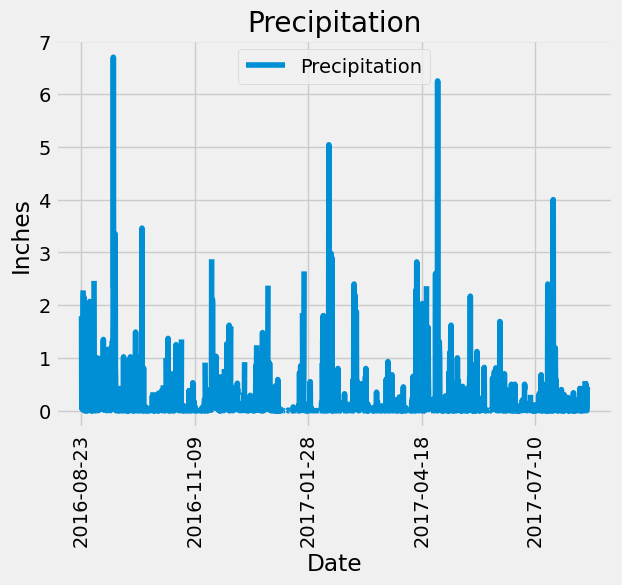

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
latest_date = session.query(func.date(func.date('2017-08-23', '-1 year'))).scalar()

# Perform a query to retrieve the data and precipitation scores
session.query(measurement.date, measurement.prcp).filter(measurement.date >= latest_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
query_result = (
    session
    .query(measurement.date, measurement.prcp)
    .filter(func.date(measurement.date) >= latest_date)
    .all()
)
result = pd.DataFrame(query_result)
result = result.rename(columns={"date": "Date", "prcp": "Precipitation"})

# Sort the dataframe by date
result = result.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
result.plot(x="Date", y="Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation")
plt.xticks(rotation=90)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
result.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
inspector = inspect(engine)
inspector.get_table_names()
pd.DataFrame(inspector.get_columns('station'))

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).all()
total_stations

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
from sqlalchemy import desc
station_counts = session.query(station.station, func.count(measurement.station)).\
    join(measurement, station.station == measurement.station).\
    group_by(station.station).\
    order_by(desc(func.count(measurement.station))).\
    all()
for station_id, row_count in station_counts:
    print(f"Station: {station_id}, Row Count: {row_count}")

Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]

temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

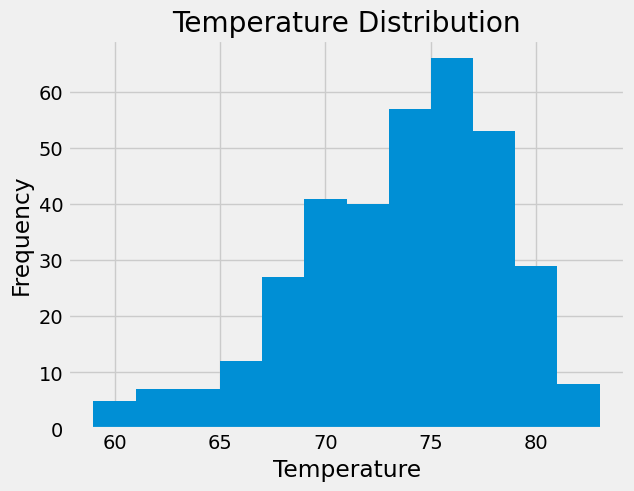

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(measurement.tobs)
    .filter(measurement.station == most_active_station)
    .filter(measurement.date >= latest_date)
    .all()
)

# Extract temperature values from the query results
temperatures = [temp[0] for temp in temperature_data]

# Create the histogram
plt.hist(temperatures, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Distribution")
plt.show()

# Close Session

In [18]:
# Close Session
session.close()